In [1]:
import numpy as np
from pandas import *
import matplotlib.pyplot as plt

# Control 2

#### Métodos Númericos para la Ciencia y la Ingeniería

#### Victor Faraggi

En este control se pide solucionar la siguiente ecuación:

$$
\frac{\partial c}{\partial t} = D \frac{\partial^2 c}{\partial x^2} + S(x)
$$

con 

$$
S(x) =
\left\{\begin{array}{lr}
                    S_0, \quad L/2 - \delta \leq x \leq L/2 + \delta \\
                    0, \quad \textrm{en caso contrario}
\end{array}\right.
$$

## Estudio del problema

La versión homogénea de la ecuación se puede diferenciar de la siguiente manera:

$$
\frac{u^{n+1}_j - u^{n}_j}{\Delta t} = D \big[ \frac{u^{n+1}_{j+1} - 2u^{n+1}_j + u^{n+1}_{j-1}}{(\Delta x)^2} \big]
$$

Donde $\vec{u} = \vec{c}(x,t)$ Reordenando lo anterior se obtiene:

$$
-\alpha u^{n+1}_{j-1} + (1+2\alpha)u^{n+1}_j - \alpha u^{n+1}_{j+1} = u^n_j
$$

donde 

$$
\alpha = \frac{D \Delta t}{(\Delta x)^2}
$$

Se nota que el sistema anterior es tridiagonal. Así, este se puede resolver utilizando un sistema de ecuaciones matriciales común. 
Basta notar ahora que el término adicional es un vector que tiene valor $S_0$ en el intervalo $[L/2 - \delta , L/2 + \delta]$.

Asímismo, para este problema se tienen condiciones de borde de Dirichlet nulas.

De esta manera se tienen las siguientes matrices:


$$
\scriptsize
A=
\begin{bmatrix}
1+2\alpha & -\alpha & 0 & 0 & 0 & \cdots & 0 & 0 & 0 & 0\\\\
-\alpha & 1+2\sigma & -\alpha & 0 & 0 & \cdots & 0 & 0 & 0 & 0 \\\\
0 & -\alpha & 1+2\alpha & -\alpha & \cdots & 0 & 0 & 0 & 0 & 0 \\\\
0 & 0 & \ddots & \ddots & \ddots & \ddots & 0 & 0 & 0 & 0 \\\\
0 & 0 & 0 & 0 & 0 & 0 & 0 & -\alpha & 1+2\alpha & -\alpha \\\\
0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & -\alpha & 1+2\alpha
\end{bmatrix},
\space
\mathbf{U^{n+1}}=
\begin{bmatrix}
U_0^{n+1} \\\\
U_1^{n+1} \\\\
U_2^{n+1} \\\\
\vdots \\\\
U_{J-2}^{n+1} \\\\
U_{J-1}^{n+1}
\end{bmatrix},
\space
\scriptsize
\mathbf{U^{n}}=
\begin{bmatrix}
U_0^{n+1} \\\\
U_1^{n+1} \\\\
U_2^{n+1} \\\\
\vdots \\\\
U_{J-2}^{n+1} \\\\
U_{J-1}^{n+1}
\end{bmatrix},
\space
\scriptsize
{S}=
\begin{bmatrix}
0 \\\\
0 \\\\
\vdots \\\\
S_0 \\\\
\vdots \\\\
S_0 \\\\
\vdots \\\\
0 \\\\
0
\end{bmatrix}
$$

Esto se traduce a la siguiente ecuación matricial:

$$
A\mathbf{U^{n+1}} = \mathbf{U^n} + S
\\
\iff
\\
\mathbf{U}^{n+1} = A^{-1} \left(\mathbf{U}^n + S \right)
$$

## Inicializaciones

Ahora se definen las constantes del problema:

In [2]:
## Constantes
L = 13.15
delta = 1
D = 1
S_0 = 5
T_end = 10.0
N = [100, 500, 1000]


## Discretización
delta_t = 0.01
deltas_x = [float(L)/float(n) for n in N]
t_grid = np.linspace(0, T_end, num=int(T_end/delta_t))
x_grid = [np.linspace(0, L, num=int(n)) for n in N]
 
alphas = [D*delta_t/(dx)**2 for dx in deltas_x]

## alphas[1] ---> N[1], se tiene un alpha para cada valor de N

Se definen las matrices $A$ y $S$:

In [3]:
## Se crean A's con != N (==> != alpha)
## Estan ordenados como lista de != n

A_s = []
for val_alpha, n in enumerate(N):
    A = np.diagflat([-alphas[val_alpha] for i  in range(n-1)], 1) +\
    np.diagflat([1 + 2*alphas[val_alpha] for i in range(n)])+\
    np.diagflat([-alphas[val_alpha] for i in range(n-1)], -1)
    A_s.append(A)

# Se crean S's para != N
S_s = []
for n in N:
    S = np.zeros((n,))
    for i in range(len(S)):
        if int(n/2-delta*(n/L)) <= i and i <= int(n/2+delta*(n/L)):
            S[i] = S_0
    S_s.append(S)

Se tienen las matrices A y S para diferentes cantidades de nodos espaciales (diferentes valores de N). 

Las matrices A tienen diferentes valores de $\alpha$ asociado a cada valor de N.

Se recuerda que la condición inicial es la siguiente: $c(x,0) = 0$.

Así, se inicializan vectores $\mathbf{U}$ que respetan la condición anterior. Cada vector corresponde a diferentes valores de N.

In [4]:
U_s = []
for n in N:
    U = np.array([0 for x in range(0,n)])
    U_s.append(U)

En resumen, se inicializó lo siguiente:
1. Matrices $A$ para cada valor de N (por ende diferente valores de $alpha$).
2. Vectores $S$ para cada valor de N
3. Vectores $\mathbf{U}$ para cada valor de N

## Resolución del problema

Ahora, se puede proceder a resolver la ecuación para cada valor de N. Para esto se define una función que recibe sólo una Matriz $A$, un vector $S$ y un vector $\mathbf{U}$. 

Se recuerda que se utilizan condiciones de borde de Dirichlet nulas.

Así, para resolver para cada valor de N, se debe llamar a esta función cada vez con los parámetros correspondientes.

Se define el método:

In [5]:
def metodo(A, S, U, x_grid, t_grid=t_grid):
    ## x_grid sirve para graficar, este valor depende de que N se usó
    
    U_sol = []
    U_sol.append(U)
    
    ## Se resuelve la primera iteración
    U_n = np.linalg.solve(A, U + S)
    
    ## Condicones de Dirchlet
    U_n[0] = 0
    U_n[-1] = 0
    
    ## Actualizamos
    U = U_n

    #Guardamos para poder graficar
    U_sol.append(U)
    
    # Se resuelve para el resto del tiempo
    for t in range(len(t_grid) - 2):
        U_n = np.linalg.solve(A, U + S)
        
        ## Condicones de Dirchlet
        U_n[0] = 0
        U_n[-1] = 0
        
        ## Actualizamos
        U = U_n
        
        #Guardamos para poder graficar
        U_sol.append(U)
        
        ## grafico 1, 2, 3
        if t == len(t_grid)//8:
            U_graf_1 = np.array(U_sol)
        if t == len(t_grid)//6:
            U_graf_2 = np.array(U_sol)
        if t == len(t_grid)//3:
            U_graf_3 = np.array(U_sol)
    
    #end for  
            
    ## Se grafica
    x_grid = np.array(x_grid)
    U_sol = np.array(U_sol)
    
    ## Reshapes
    t_grid_1 = t_grid[:(len(t_grid)//8 +3)]
    U_graf_1 = np.array(U_graf_1)
    
    t_grid_2 = t_grid[:len(t_grid)//6 +3]
    U_graf_2 = np.array(U_graf_2)
    
    t_grid_3 = t_grid[:len(t_grid)//3 +3]
    U_graf_3 = np.array(U_graf_3)


    ## Primer grafico
    fig, ax = plt.subplots()
    plt.xlabel('x') 
    plt.ylabel('t')

    heatmap = ax.pcolor(x_grid,  t_grid_1, U_graf_1, vmin= -1, vmax = 1)
    ax.set_title('Concentracion c(x,t) en un octavo del tiempo')
    colorbar = plt.colorbar(heatmap)
    
    ## Segundo grafico
    fig, ax = plt.subplots()
    plt.xlabel('x') 
    plt.ylabel('t')
    
    heatmap = ax.pcolor(x_grid, t_grid_2, U_graf_2)
    ax.set_title('Concentracion c(x,t) en un cuarto del tiempo')
    colorbar = plt.colorbar(heatmap)
    
    
    ## Tercer grafico
    fig, ax = plt.subplots()
    plt.xlabel('x') 
    plt.ylabel('t')
    
    heatmap = ax.pcolor(x_grid, t_grid_3, U_graf_3)
    ax.set_title('Concentracion c(x,t) en un tercio del tiempo')
    colorbar = plt.colorbar(heatmap)
    
    
    ## 4to grafico
    fig, ax = plt.subplots()
    plt.xlabel('x') 
    plt.ylabel('t')
    
    heatmap = ax.pcolor(x_grid, t_grid, U_sol)
    ax.set_title('Concentracion final')
    colorbar = plt.colorbar(heatmap) 
    
    ##Grafico de evolucion
    fig, ax = plt.subplots()
    ax.plot(x_grid, U_graf_1[-1], label='Octavo de tiempo')
    ax.plot(x_grid, U_graf_2[-1], label='Cuarto de tiempo')
    ax.plot(x_grid, U_graf_3[-1], label='Tercio de tiempo')
    ax.plot(x_grid, U_sol[-1], label='Situacion final')
    ax.legend()
    ax.set_xlabel('x')
    ax.set_ylabel('concentracion')
    ax.set_title('Evolucion de la concentracion c(x,t) con respecto a la posicion')

Ahora, se puede resolver para cada valor de N:

Resolucion para N =  100  con alpha =  0.5782937443074209


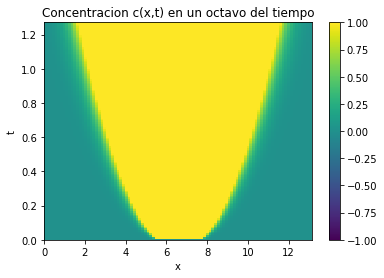

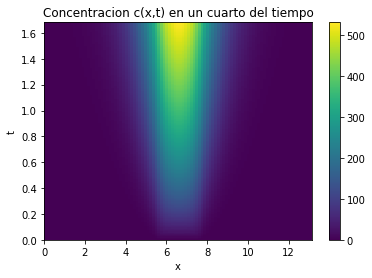

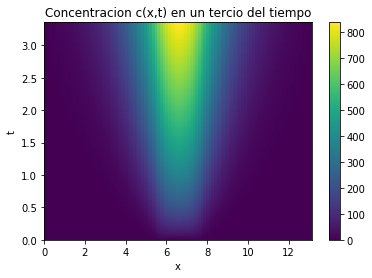

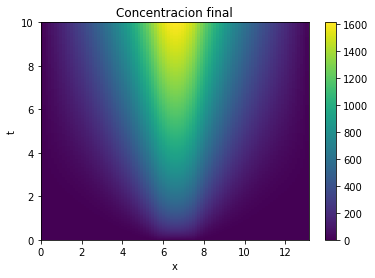

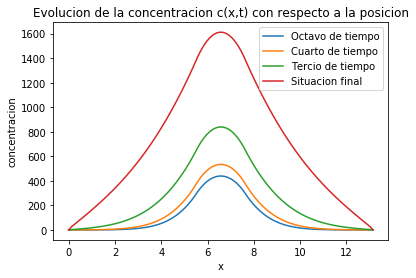

In [6]:
print("Resolucion para N = ", N[0], " con alpha = ", alphas[0])
metodo(A_s[0], S_s[0], U_s[0], x_grid[0])

Resolucion para N =  500  con alpha =  14.457343607685523


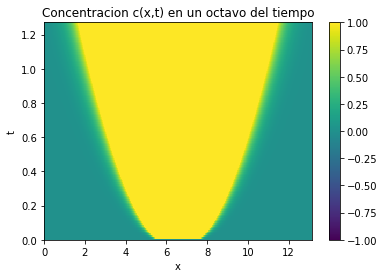

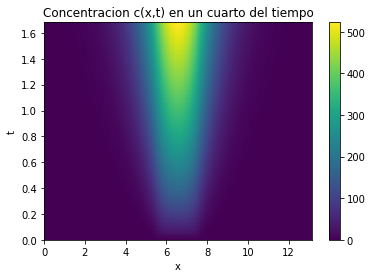

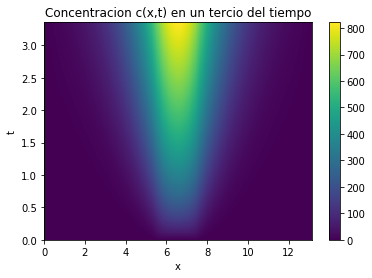

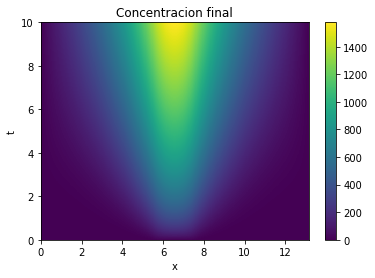

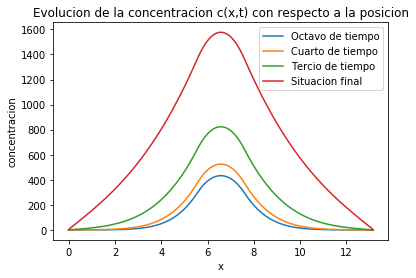

In [7]:
print("Resolucion para N = ", N[1], " con alpha = ", alphas[1])
metodo(A_s[1], S_s[1], U_s[1], x_grid[1])

Resolucion para N =  1000  con alpha =  57.82937443074209


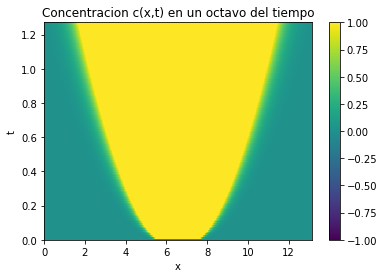

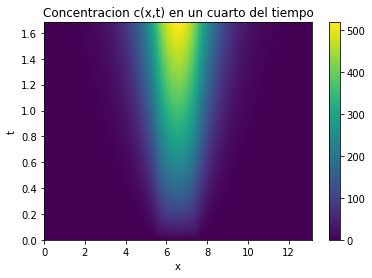

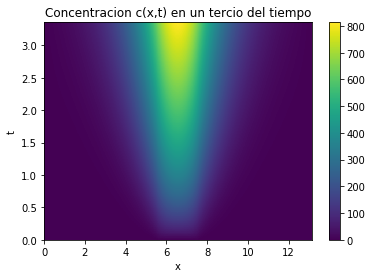

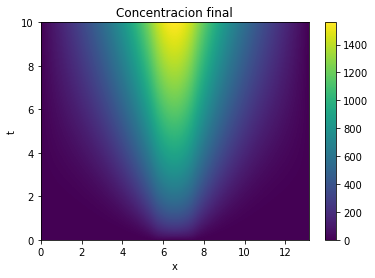

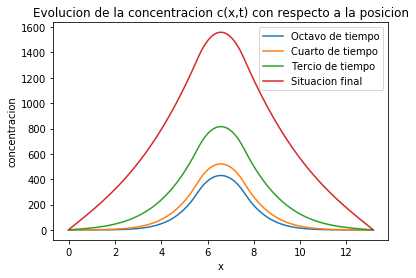

In [8]:
print("Resolucion para N = ", N[2], " con alpha = ", alphas[2])
metodo(A_s[2], S_s[2], U_s[2], x_grid[2])

## Observación y Análisis de los resultados

#### 1. Con respecto a la evolución de la concentración:

Se puede apreciar la difusión de la especie de moléculas a lo largo del canal. A medida que pasa el tiempo, las moléculas se propagan hacia los bordes del canal. 

Estas mantienen una alta concentración en la parte central debido a la reacción. La propagación empieza de manera *suave o distribuida* (parecido a una distribución gaussiana incluso) para luego tomar una forma más triangular. Siempre se tiene una mayor concentración en el medio de la barra dado que es donde tiene lugar la reacción a lo largo del tiempo.  Estas dos situaciones son esperadas debido a la configuración del problema.

Finalmente, se llega a tener una concentración nula en los bordes de este. 

#### 2. Con respecto al incremento de nodos espaciales:

El aumento de los nodos espaciales permite tener un mayor detalle sobre la evolución del fenómeno. Sin embargo, este detalle no es destacable. Así, se puede calificar que el aumento de nodos más que ser un aporte genera una mayor carga computacional al momento de resolver el problema. 

El aumento de nodos podría tener un efecto positivo si el largo del canal fue mayor que el dado.

#### General

De manera general, se puede afirmar que la simulación realizada es correcta ya que el comportamiento presentado concuerda con la intuición física del problema que se busca modelar.

## Exploración de parámetros

En esta última parte se busca variar el valor de $\delta t$ manteniendo $\delta x $ constante.

Se decide utilizar 100 nodos espaciales dada las observaciones anteriores. 

De la misma manera se definen los siguiente valores de $\delta t$ a estudiar:

In [9]:
deltas_t = [0.05, 0.1, 0.5, 1]

Redefinen grillas temporales de manera adecuada para cada uno de los valores anteriores:

In [10]:
t_grids = [np.linspace(0, T_end, num=int(T_end/dt)) for dt in deltas_t]

Se inicializan los parámetros:

In [11]:
## Parametros
N = 100
delta_x = float(L)/float(N)
print("El valor de dx es: ", delta_x)
alphas = [D*dt/(delta_x)**2 for dt in deltas_t]

## Grilla espacial
x_grid = np.linspace(0, L, num=int(N))

## Matriz S
S = np.zeros((N,))
for i in range(len(S)):
    if int(N/2-delta*(N/L)) <= i and i <= int(N/2+delta*(N/L)):
        S[i] = S_0

El valor de dx es:  0.1315


Se nota que la matriz $S$ se mantiene constante para cada valor de $\Delta t$ ya que estos no producen cambio en ella.

Se resuelve para cada valor $\Delta t$:

Resolucion para dt =  0.05


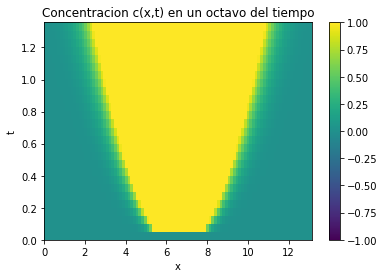

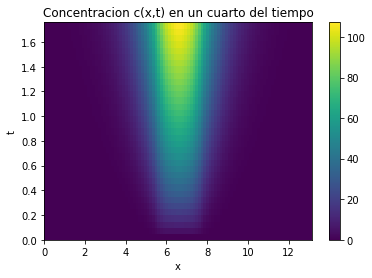

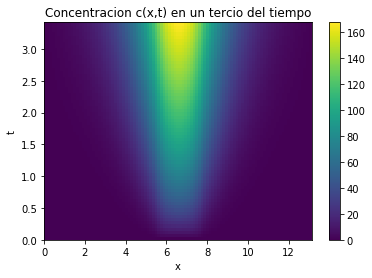

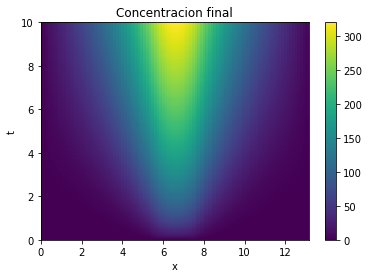

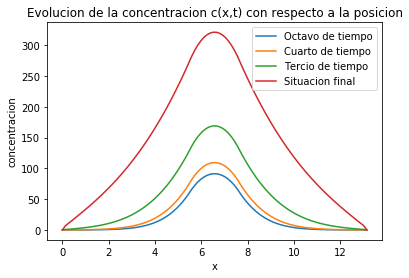

In [12]:
print("Resolucion para dt = ", deltas_t[0])

## Condiciones iniciales

## Matriz A
A = np.diagflat([-alphas[0] for i  in range(N-1)], 1) +\
np.diagflat([1 + 2*alphas[0] for i in range(N)])+\
np.diagflat([-alphas[0] for i in range(N-1)], -1)

##Condicion Inicial
U = np.array([0 for x in range(0,N)])

metodo(A, S, U, x_grid, t_grids[0])

Resolucion para dt =  0.1


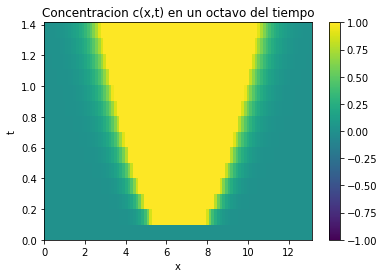

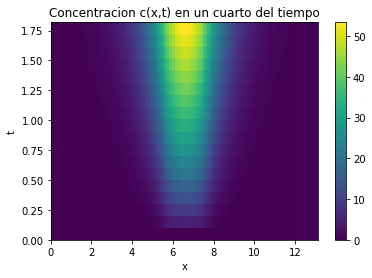

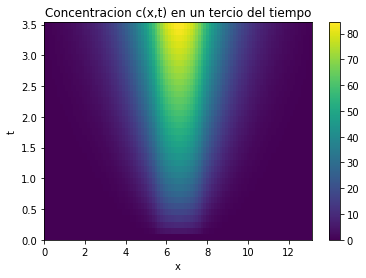

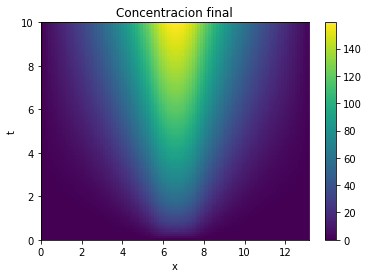

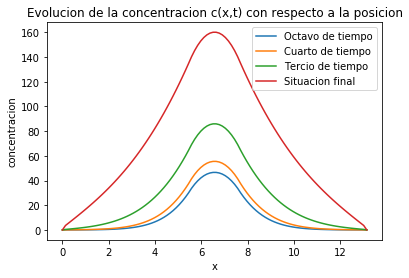

In [13]:
print("Resolucion para dt = ", deltas_t[1])

## Condiciones iniciales

## Matriz A
A = np.diagflat([-alphas[1] for i  in range(N-1)], 1) +\
np.diagflat([1 + 2*alphas[1] for i in range(N)])+\
np.diagflat([-alphas[1] for i in range(N-1)], -1)

##Condicion Inicial
U = np.array([0 for x in range(0,N)])

metodo(A, S, U, x_grid, t_grids[1])

Resolucion para dt =  0.5


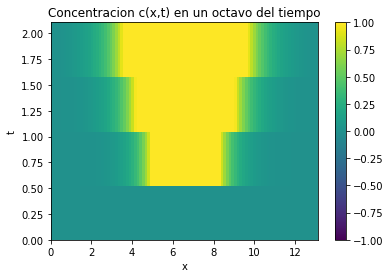

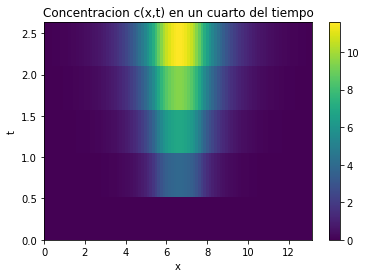

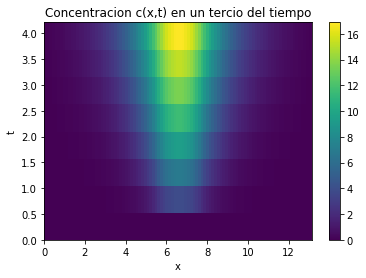

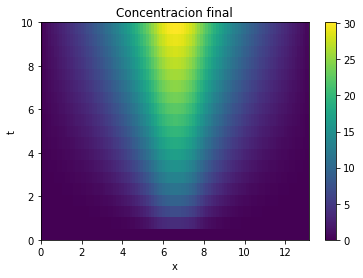

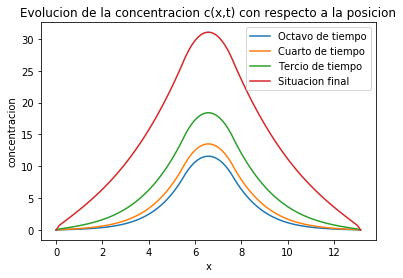

In [14]:
print("Resolucion para dt = ", deltas_t[2])

## Matriz A
A = np.diagflat([-alphas[2] for i  in range(N-1)], 1) +\
np.diagflat([1 + 2*alphas[2] for i in range(N)])+\
np.diagflat([-alphas[2] for i in range(N-1)], -1)

## Condiciones iniciales
U = np.array([0 for x in range(0,N)])

metodo(A, S, U, x_grid, t_grids[2])

Resolucion para dt =  1


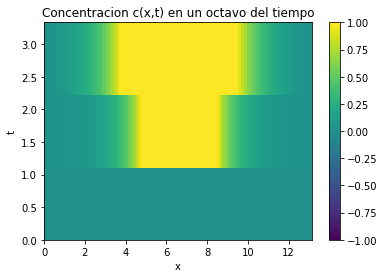

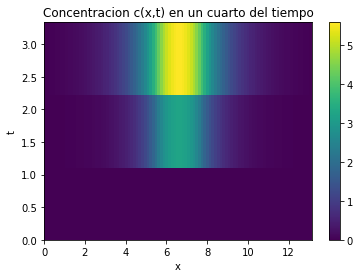

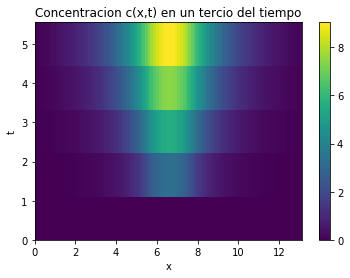

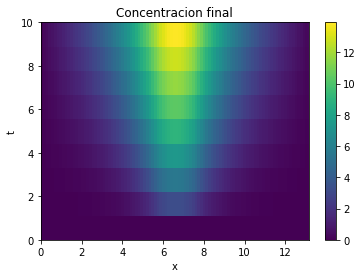

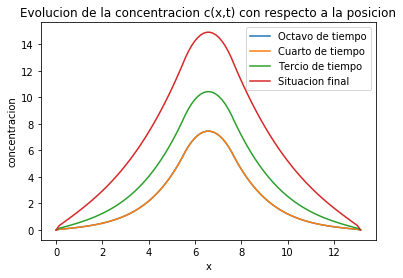

In [15]:
print("Resolucion para dt = ", deltas_t[3])

## Matriz A
A = np.diagflat([-alphas[3] for i  in range(N-1)], 1) +\
np.diagflat([1 + 2*alphas[3] for i in range(N)])+\
np.diagflat([-alphas[3] for i in range(N-1)], -1)

##Condicion Inicial
U = np.array([0 for x in range(0,N)])

metodo(A, S, U, x_grid, t_grids[3])

#### Observaciones

Se puede apreciar que para los distintos valores de $\Delta t$ el método se comporta de buena manera. A pesar de tener un *detalle* (detalles de la evolución temporal) que parece preciso en los `heatmap`. El comportamiento de la concentración concuerda con lo anteriormente calculado. Así, el método parece ser estable sin importar que valor tenga $\Delta t$. 

Se podría realizar el mismo experimento pero con $\Delta t$ constante y $\Delta x$ variable  (o incluso variar el valor $D$) para determinar la influencia de otros parámetros en el comportamiento del método. 

### Posibles Errores

1. No se pudo respetar los valores de `vmin` y `vmax`. Esto es extraño y puede ser un error de la función misma.
2. Se cree que se realizan una o dos iteraciones *de más* en el método. Por esto se debe sumar 3 valores temporales más al momento de graficar con `heatmap`.
3. Mala implementación del método. Este método es bastante similar al de `Crank-Nicolson`. Sin embargo, recién la última tarea trataba este último. Así, no es posible saber si lo que realice para la tarea estaba correcto. Por ende, no se puede saber si en lo que me basé para este control estaba correcto.
4. Puede que todo este malo y no me di cuenta u.u